# Step 1 : Load DNA methylation Data downloaded from GEO
* Probes that are associated with tobacco smoking are removed from the analysis


In [63]:
library(data.table)
options(repr.plot.width=7, repr.plot.height=7)
tobacco_schizo <- c("cg05575921",
                    "cg01940273",
                    "cg26703534",
                    "cg03636183",
                    "cg05951221",
                    "cg25952192",
                    "cg03274391",
                    "cg01772743",
                    "cg13862853",
                    "cg20566897")


sample_id_test <- read.csv("./GEO/E-GEOD-80417.sdrf.txt",sep = "\t")
sample_id_train <- read.csv("./GEO/E-GEOD-84727.sdrf.txt",sep = "\t")

test <- fread("./GEO/GSE80417_normalizedBetas.csv", header = T)
train <- fread("./GEO/GSE84727_normalisedBetas.csv", header = T)

common_probes <- intersect(train$V1,test$V1)
common_probes <- setdiff(common_probes,tobacco_schizo)

train <- subset(train, V1 %in% common_probes)
test <- subset(test, V1 %in% common_probes)

# Step 2 : Run Variable Selection from CoRSIVs probes using Traning dataset

In [80]:
library(mixOmics)
library(ggpubr)

In [2]:
CoRSIV_Probes<- read.csv("./hm450k_probes/CoRSIV_ESS_SIV_CG_sites_clusters_hg38.csv",
                         header = T,stringsAsFactors = F,sep = ",")
train_corsiv <- subset(train, V1 %in% CoRSIV_Probes$CG)

colnames_train_corsiv <- train_corsiv$V1
train_corsiv$V1 <- NULL
train_corsiv_t <- data.frame(t(train_corsiv))
colnames(train_corsiv_t) <- colnames_train_corsiv
train_corsiv_t$sample.id <- rownames(train_corsiv_t)
rownames(train_corsiv_t) <- NULL

In [3]:
train_corsiv <- data.frame(merge(sample_id_train,train_corsiv_t,by.x = "id",by.y = "sample.id"))

In [4]:
source("./R/functions.R")
train_corsiv <- average_corsiv_methylation(train_corsiv)

In [5]:
head(train_corsiv)

id                  sample_title status cg23733394 cg10955566 cg18224942
1 100973330060_R01C01 33261736     1      0.3644638  0.8457367  0.3703085 
2 100973330060_R02C01 12763949     2      0.3195477  0.7428692  0.4062422 
3 100973330060_R02C02 12764456     2      0.3511180  0.7411625  0.3773150 
4 100973330060_R03C01 33262072     2      0.2753760  0.6831573  0.4495098 
5 100973330060_R03C02 33262309     1      0.2770437  0.7531286  0.3872392 
6 100973330060_R04C01 33262428     2      0.4027250  0.8065256  0.3866389 
  cg12639453 cg20300514 cg07700843 cg14508832 <U+22EF>   cg05992904 cg04930211
1 0.4916441  0.3464452  0.9212488  0.6973672  <U+22EF> 0.8534073  0.7875277 
2 0.5379860  0.3851716  0.7940525  0.7622755  <U+22EF> 0.7260245  0.8438749 
3 0.5059654  0.4353690  0.9109643  0.7346413  <U+22EF> 0.7422258  0.7876081 
4 0.4533544  0.3825308  0.9028881  0.7174365  <U+22EF> 0.8584500  0.7635320 
5 0.4412441  0.2491474  0.8630541  0.6900322  <U+22EF> 0.7358945  0.7859730 
6 0.4038895  0.3556109  0.9207089  0.7627791  <U+22EF> 0.6850164  0.8145886 
  cg15706568 cg01652190 cg04121214 cg06357843 cg19214594 cg02447733 cg22910549
1 0.7640273  0.4758052  0.8699379  0.7357890  0.08883140 0.9025306  0.6519121 
2 0.6837290  0.7729899  0.8552654  0.7167203  0.08670115 0.9145798  0.7243251 
3 0.7194961  0.5356647  0.8877367  0.6194815  0.09650842 0.8838107  0.6296201 
4 0.6425274  0.5557288  0.8665416  0.7399168  0.07845348 0.9169635  0.7525034 
5 0.5727964  0.4907530  0.8719391  0.6856860  0.08895411 0.8721175  0.7379286 
6 0.5563299  0.7118163  0.8892109  0.6378393  0.08515158 0.9115419  0.6957731 
  cg17852224
1 0.2620324 
2 0.2568227 
3 0.1568971 
4 0.2152615 
5 0.1909685 
6 0.2527299

In [6]:
train_corsiv_ids <- train_corsiv$id
train_corsiv$id <- NULL
train_corsiv$sample_title <- NULL
train_corsiv$status <- as.factor(ifelse(train_corsiv$status==1,0,1))

In [10]:
Y <- train_corsiv$status
X <- train_corsiv[,-1]
list.keepX <- seq(10,200,50)
tune.splsda.corsiv <- tune.splsda(X, Y, ncomp =6 , validation = 'Mfold', folds = 5, 
                           progressBar = TRUE, dist = 'max.dist', measure = "AUC",
                          test.keepX = list.keepX, nrepeat = 10, cpus = 6)


comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%
comp 6 
  |======================================================================| 100%


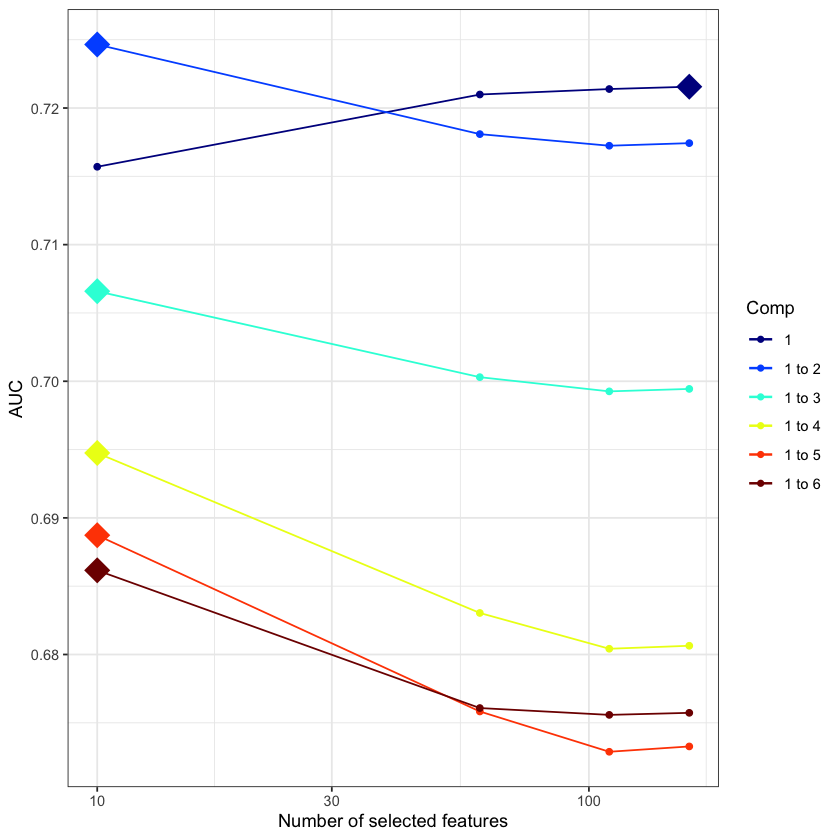

In [11]:
plot(tune.splsda.corsiv, col = color.jet(6))

In [ ]:
splsda.corsiv <- splsda(X, Y, ncomp = 2, keepX = c(100,100)) 
v <- plotIndiv(splsda.corsiv, legend=TRUE,comp = c(1,2),
               ellipse = T, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"SZ case-control"))
plsdaDF <- as.data.frame(v$df)
v$df$x <- -1*v$df$x
v$df$y <- -1*v$df$y
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))


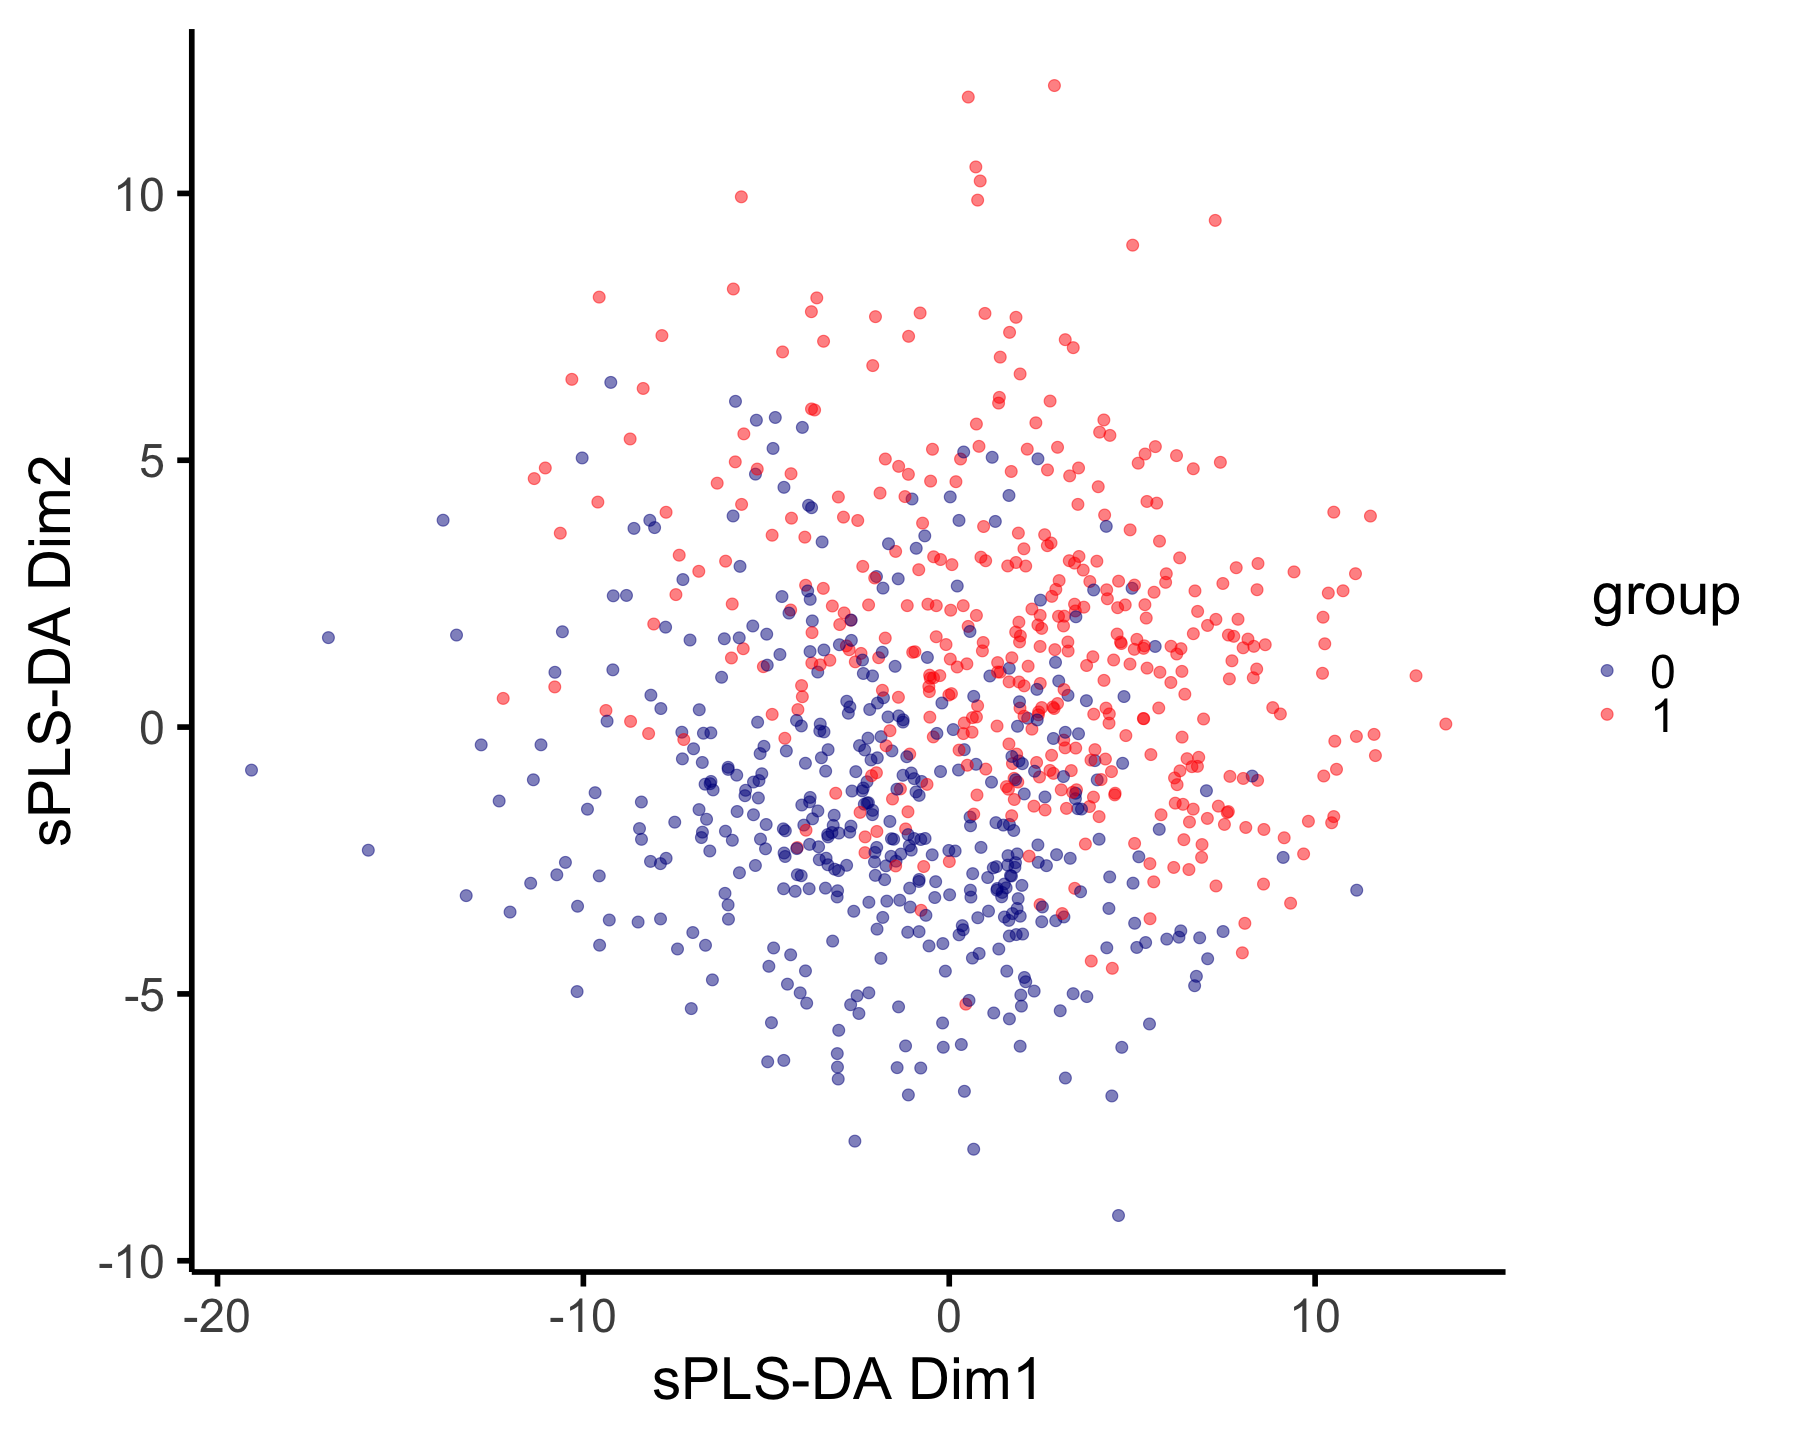

In [24]:
sp <- ggscatter(v$df, x = "x", y = "y",show.legend.text=FALSE,
                color = "group", palette = c("darkblue","red"),
                size = 3, alpha = 0.5, ggtheme = theme_classic(base_size = 35)) + xlab("sPLS-DA Dim1") +ylab("sPLS-DA Dim2")
sp

# Step 3 : Run Variable Selection from Top 2500 Range(2%-98%) probes using Traning dataset


In [37]:
Range_Probes<- read.csv("./hm450k_probes/Top_98_2_range_probes.csv",header = T,stringsAsFactors = F,sep = ",")

In [38]:
train_range <- subset(train, V1 %in% setdiff(Range_Probes$CG,CoRSIV_Probes$CG))

In [39]:
colnames_train_range <- train_range$V1
train_range$V1 <- NULL
train_range_t <- data.frame(t(train_range))
colnames(train_range_t) <- colnames_train_range
train_range_t$sample.id <- rownames(train_range_t)
rownames(train_range_t) <- NULL

In [40]:
train_range <- data.frame(merge(sample_id_train,train_range_t,by.x = "id",by.y = "sample.id"))

In [42]:
head(train_range)

id                  sample_title status cg00021855 cg00022997 cg00035636
1 100973330060_R01C01 33261736     1      0.6017636  0.6537924  0.4591614 
2 100973330060_R02C01 12763949     2      0.3596101  0.6822409  0.7337174 
3 100973330060_R02C02 12764456     2      0.5594849  0.3247824  0.4169719 
4 100973330060_R03C01 33262072     2      0.5519438  0.5954009  0.5190144 
5 100973330060_R03C02 33262309     1      0.6675778  0.5367404  0.1776900 
6 100973330060_R04C01 33262428     2      0.6272365  0.5756276  0.3066537 
  cg00050402 cg00056489 cg00083206 cg00084338 <U+22EF>   cg27447006 cg27519373
1 0.4771303  0.93779272 0.2669922  0.5633059  <U+22EF> 0.5175869  0.6464823 
2 0.4458708  0.92901351 0.6513235  0.4923096  <U+22EF> 0.5385106  0.6629915 
3 0.3697453  0.09660606 0.4839397  0.6769055  <U+22EF> 0.4899002  0.6526343 
4 0.5349200  0.95322836 0.2850753  0.4999760  <U+22EF> 0.5427657  0.3042152 
5 0.4765612  0.95397796 0.5360653  0.5889868  <U+22EF> 0.5162428  0.7323080 
6 0.4997860  0.94998692 0.5495872  0.5529345  <U+22EF> 0.4788825  0.6415352 
  cg27535302 cg27572370 cg27573991 cg27601169 cg27606822 cg27621897 cg27638615
1 0.7664720  0.5589818  0.6426697  0.7695349  0.7748374  0.7545463  0.4307026 
2 0.7432153  0.4405358  0.3319547  0.7851817  0.7953354  0.7707877  0.6034608 
3 0.7752639  0.5177372  0.6883364  0.7917329  0.7974748  0.7702400  0.7182529 
4 0.8481023  0.6262399  0.4422465  0.7425459  0.8421708  0.7633187  0.6268698 
5 0.7595267  0.2908181  0.5902167  0.8060276  0.8286869  0.7698270  0.2722816 
6 0.7976561  0.6273475  0.4061305  0.8180723  0.8101135  0.7777504  0.5977264 
  cg27655855
1 0.8377837 
2 0.8466647 
3 0.8444255 
4 0.8569558 
5 0.8118087 
6 0.8415681

In [44]:
train_range$id <- NULL
train_range$sample_title <- NULL
train_range$status <- as.factor(ifelse(train_range$status==1,0,1))

In [45]:
Y <- train_range$status
X <- train_range[,-1]
list.keepX <- seq(10,200,50)
tune.splsda.range <- tune.splsda(X, Y, ncomp =6 , validation = 'Mfold', folds = 5, 
                           progressBar = TRUE, dist = 'max.dist', measure = "AUC",
                          test.keepX = list.keepX, nrepeat = 10, cpus = 6)


comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%
comp 6 
  |======================================================================| 100%


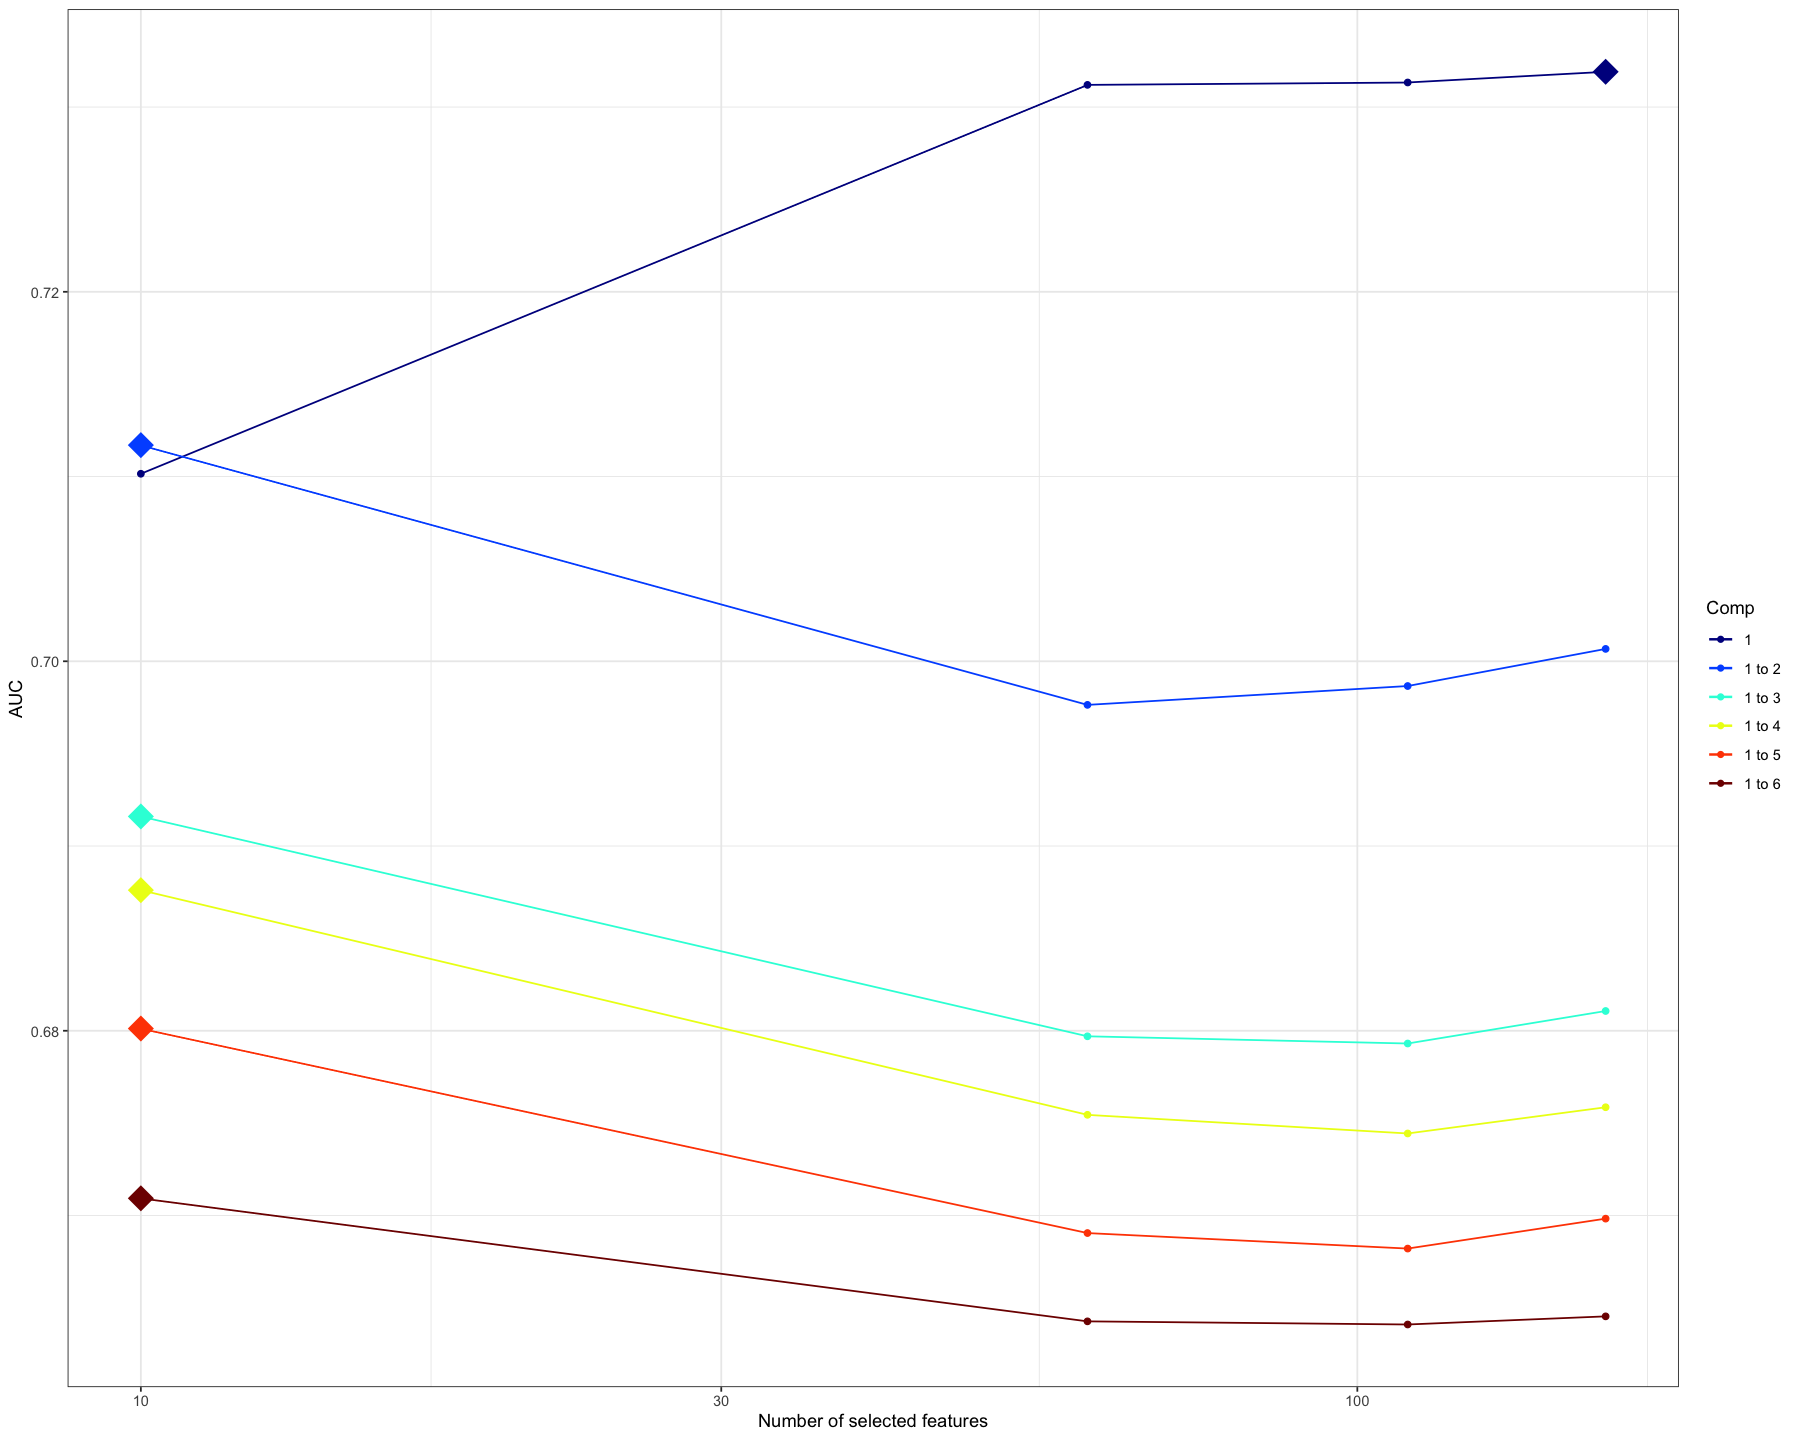

In [47]:
plot(tune.splsda.range, col = color.jet(6))

In [ ]:
splsda.range <- splsda(X, Y, ncomp = 2, keepX = c(100,100)) 
v <- plotIndiv(splsda.range, legend=TRUE,comp = c(1,2),
               ellipse = T, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"SZ case-control"))
plsdaDF <- as.data.frame(v$df)
v$df$x <- -1*v$df$x
v$df$y <- -1*v$df$y
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))


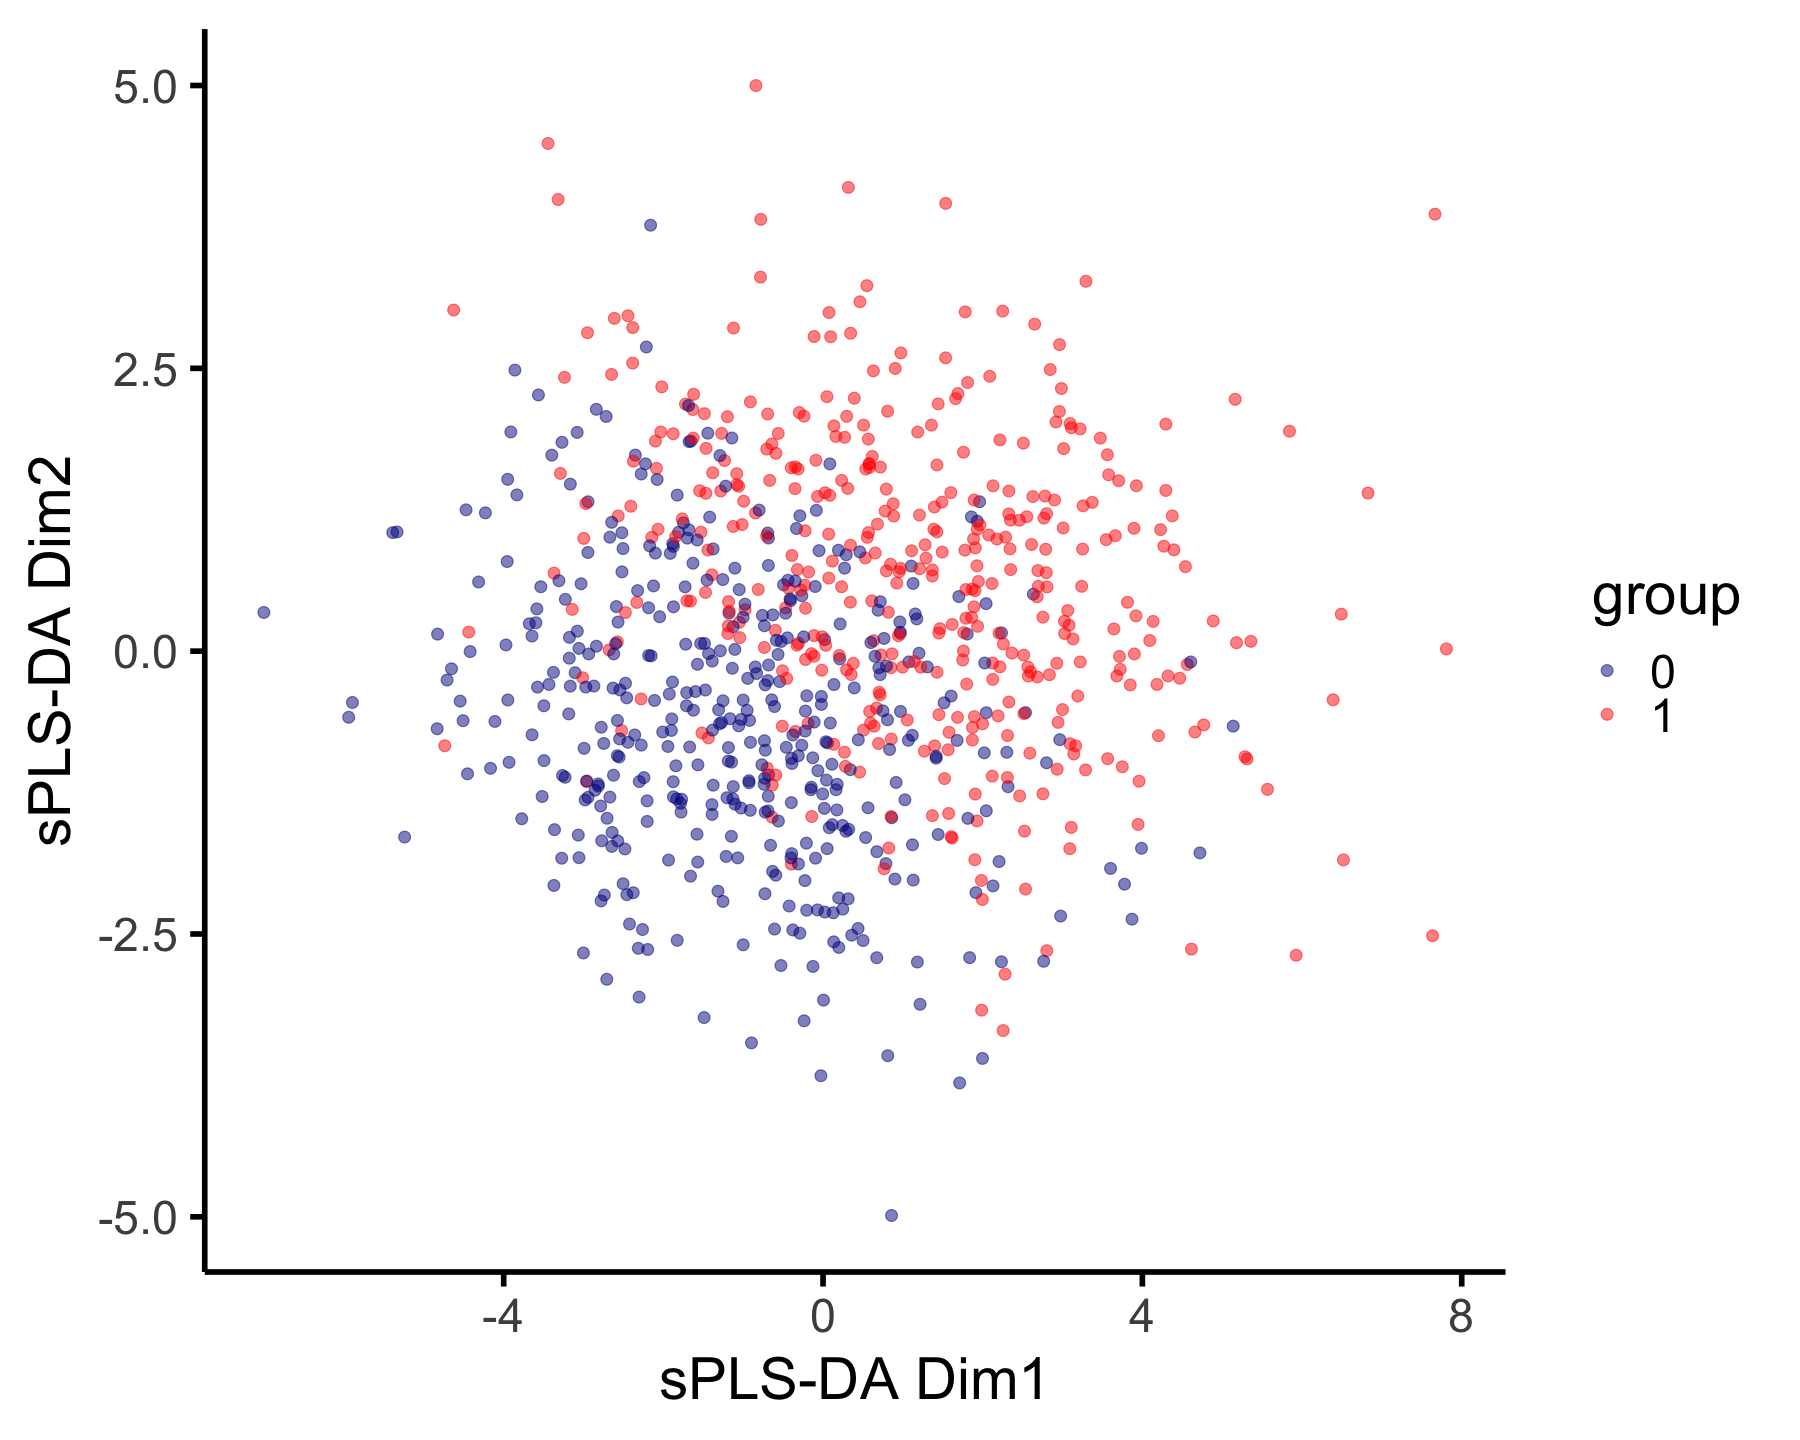

In [52]:
sp <- ggscatter(v$df, x = "x", y = "y",show.legend.text=FALSE,
                color = "group", palette = c("darkblue","red"),
                size = 3, alpha = 0.5, ggtheme = theme_classic(base_size = 35)) + xlab("sPLS-DA Dim1") +ylab("sPLS-DA Dim2")
sp

# Step 4: Incorporate Selected CoRSIV/Range Variables , clinical variables (smoking score) and blood cell ratios to train final model

In [64]:
Aberdeen_covariates <- read.csv("./data_sources/AdditionalCovariatesAberdeen.csv")
head(Aberdeen_covariates)
UCL_covariates <- read.csv("./data_sources/AdditionalCovariatesUCL.csv")
head(UCL_covariates)

Basename          smokingScore PlasmaBlast CD8pCD28nCD45RAn CD8.naive
1 3998567027_R01C01 13.076251    1.748857    12.453208        153.5598 
2 3998567027_R02C01 11.166418    1.802734    13.861751        159.9287 
3 3998567027_R03C01 11.094193    1.628653    12.059060        190.0643 
4 3998567027_R04C01 14.373015    1.922215    16.537051        192.9703 
5 3998567027_R05C01 15.883060    1.893910     6.951288        213.0875 
6 3998567027_R06C01  9.698782    1.752264     9.085465        215.9612 
  CD4.naive CD8T       CD4T       NK         Bcell      Mono       Gran     
1 449.9774  0.08930741 0.12998327 0.02912801 0.02741193 0.08193897 0.6071240
2 427.5157  0.03183639 0.11270767 0.06277872 0.02924390 0.09537986 0.6377389
3 482.3159  0.03133318 0.12593794 0.01476804 0.02936250 0.06535940 0.7088081
4 282.5089  0.04313376 0.07832868 0.04027046 0.04581906 0.06070829 0.7314893
5 413.8030  0.05330391 0.10086438 0.00000000 0.09904410 0.05068844 0.6843186
6 512.3938  0.03009161 0.11830703 0.02959263 0.04685475 0.06949262 0.6931092
  cloz
1 NA  
2 NA  
3  1  
4 NA  
5 NA  
6  1

Basename          PlasmaBlast CD8pCD28nCD45RAn CD8.naive CD4.naive CD8T      
1 9704031032_R02C01 1.503589     7.907739        309.7345  461.7186  0.10736089
2 9704031032_R06C01 1.570982    12.401518        145.5583  307.5373  0.04403277
3 9721367113_R04C02 1.591187    15.322913        163.8781  320.1196  0.07460840
4 9721367113_R05C01 1.586029     9.040199        225.5692  427.6956  0.05031361
5 9721367113_R06C01 1.705579    10.270772        165.6787  190.5521  0.04027610
6 9721367113_R06C02 1.636100     7.633269        276.2883  498.3339  0.06473530
  CD4T       NK          Bcell      Mono       Gran      smokingScore cloz
1 0.15189216 0.000000000 0.03897269 0.06405199 0.5749416 -3.656180    NA  
2 0.14440800 0.038900309 0.04714918 0.08341840 0.6166383 -2.177073    NA  
3 0.08165123 0.008136236 0.05599000 0.10984418 0.6012898  9.033510    NA  
4 0.06641923 0.059124241 0.02720509 0.11597642 0.6128118  5.673556     0  
5 0.11180634 0.042163734 0.03843766 0.07071841 0.6267167 -3.063196    NA  
6 0.14295427 0.000000000 0.04120657 0.07732079 0.5964837 -2.282893    NA

In [65]:
model1 <-read.csv("./model_variables/model_corsiv.csv")
model2 <-read.csv("./model_variables/model_range.csv")
selected_variables <- rbind(model1,model2)
selected_variables  <- selected_variables[!(duplicated(selected_variables$probe_id)),]

In [66]:
train_final <- subset(train, V1 %in% selected_variables$probe_id)
test_final <- subset(test, V1 %in% selected_variables$probe_id)

In [67]:
colnames_train_final <- train_final$V1
train_final$V1 <- NULL
train_final_t <- data.frame(t(train_final))
colnames(train_final_t) <- colnames_train_final
train_final_t$sample.id <- rownames(train_final_t)
rownames(train_final_t) <- NULL

In [68]:
colnames_test_final <- test_final$V1
test_final$V1 <- NULL
test_final_t <- data.frame(t(test_final))
colnames(test_final_t) <- colnames_test_final
test_final_t$sample.id <- rownames(test_final_t)
rownames(test_final_t) <- NULL

In [69]:
train_final <- data.frame(merge(sample_id_train,train_final_t,by.x = "id",by.y = "sample.id"))
test_final <- data.frame(merge(sample_id_test,test_final_t,by.x = "id",by.y = "sample.id"))

In [70]:
head(Aberdeen_covariates)
head(UCL_covariates)
Aberdeen_covariates$cloz <- NULL
UCL_covariates$cloz <- NULL

Basename          smokingScore PlasmaBlast CD8pCD28nCD45RAn CD8.naive
1 3998567027_R01C01 13.076251    1.748857    12.453208        153.5598 
2 3998567027_R02C01 11.166418    1.802734    13.861751        159.9287 
3 3998567027_R03C01 11.094193    1.628653    12.059060        190.0643 
4 3998567027_R04C01 14.373015    1.922215    16.537051        192.9703 
5 3998567027_R05C01 15.883060    1.893910     6.951288        213.0875 
6 3998567027_R06C01  9.698782    1.752264     9.085465        215.9612 
  CD4.naive CD8T       CD4T       NK         Bcell      Mono       Gran     
1 449.9774  0.08930741 0.12998327 0.02912801 0.02741193 0.08193897 0.6071240
2 427.5157  0.03183639 0.11270767 0.06277872 0.02924390 0.09537986 0.6377389
3 482.3159  0.03133318 0.12593794 0.01476804 0.02936250 0.06535940 0.7088081
4 282.5089  0.04313376 0.07832868 0.04027046 0.04581906 0.06070829 0.7314893
5 413.8030  0.05330391 0.10086438 0.00000000 0.09904410 0.05068844 0.6843186
6 512.3938  0.03009161 0.11830703 0.02959263 0.04685475 0.06949262 0.6931092
  cloz
1 NA  
2 NA  
3  1  
4 NA  
5 NA  
6  1

Basename          PlasmaBlast CD8pCD28nCD45RAn CD8.naive CD4.naive CD8T      
1 9704031032_R02C01 1.503589     7.907739        309.7345  461.7186  0.10736089
2 9704031032_R06C01 1.570982    12.401518        145.5583  307.5373  0.04403277
3 9721367113_R04C02 1.591187    15.322913        163.8781  320.1196  0.07460840
4 9721367113_R05C01 1.586029     9.040199        225.5692  427.6956  0.05031361
5 9721367113_R06C01 1.705579    10.270772        165.6787  190.5521  0.04027610
6 9721367113_R06C02 1.636100     7.633269        276.2883  498.3339  0.06473530
  CD4T       NK          Bcell      Mono       Gran      smokingScore cloz
1 0.15189216 0.000000000 0.03897269 0.06405199 0.5749416 -3.656180    NA  
2 0.14440800 0.038900309 0.04714918 0.08341840 0.6166383 -2.177073    NA  
3 0.08165123 0.008136236 0.05599000 0.10984418 0.6012898  9.033510    NA  
4 0.06641923 0.059124241 0.02720509 0.11597642 0.6128118  5.673556     0  
5 0.11180634 0.042163734 0.03843766 0.07071841 0.6267167 -3.063196    NA  
6 0.14295427 0.000000000 0.04120657 0.07732079 0.5964837 -2.282893    NA

In [74]:
train <- merge(train_final,Aberdeen_covariates,by.x = "id",by.y="Basename")
test <- merge(test_final,UCL_covariates,by.x = "id",by.y = "Basename")

In [75]:
TRAIN_SAMPLE_IDS <- train$id
TEST_SAMPLE_IDS <- test$id

In [76]:
#build on phase 2
train$CaseControl <- NULL
train$id <- NULL
train$sample_title <- NULL
train$status <- as.factor(ifelse(train$status==1,0,1))
train_PRS <- train$SCORE
train$SCORE <- NULL

#train$smokingScore <- NULL
#test$smokingScore <- NULL

test$CaseControl <- NULL
test$id  <- NULL
test$gender <- NULL
test$age <- NULL
test$status <- as.factor(ifelse(test$status==1,0,1))
test_PRS <- test$SCORE
test$SCORE <- NULL

In [77]:
dim(train)
head(train)

dim(test)
head(test)

[1] 847 235

status cg00117018 cg00158530 cg00159523 cg00175403 cg00326788 cg00923880
1 0      0.5021726  0.4240359  0.2764018  0.4526078  0.8553140  0.2820742 
2 1      0.3731366  0.4466228  0.3145658  0.5042548  0.8849143  0.4715864 
3 1      0.4682677  0.4213204  0.2921170  0.4458140  0.8477416  0.2916336 
4 1      0.4953445  0.5698118  0.3783251  0.4415782  0.8964611  0.2951902 
5 0      0.5064712  0.4731871  0.3419775  0.4555819  0.8783873  0.3118205 
6 1      0.4747608  0.5979082  0.4369480  0.4346929  0.8739837  0.4724115 
  cg00982641 cg01074767 cg01238044 <U+22EF>   PlasmaBlast CD8pCD28nCD45RAn
1 0.9428834  0.6532536  0.1405311  <U+22EF> 1.495034     5.010544       
2 0.9375498  0.5415517  0.6728921  <U+22EF> 1.685901     8.207607       
3 0.9567469  0.6305955  0.1488553  <U+22EF> 1.733543     6.828892       
4 0.9416441  0.3625547  0.1596042  <U+22EF> 1.709298    10.761549       
5 0.9383263  0.3798386  0.1544214  <U+22EF> 1.532281    12.364301       
6 0.9050412  0.2018080  0.1883682  <U+22EF> 1.592663     6.205416       
  CD8.naive CD4.naive CD8T       CD4T       NK         Bcell      Mono      
1 264.6102  618.5194  0.02941703 0.22219876 0.00929855 0.04103739 0.07793779
2 339.5059  627.3506  0.03422605 0.18529370 0.00000000 0.10295019 0.05221976
3 314.9606  453.3910  0.08313464 0.09884639 0.02021404 0.06240291 0.13760769
4 181.2007  441.4300  0.07552475 0.17401723 0.00000000 0.05644695 0.05296620
5 254.0565  526.9594  0.14414085 0.14015960 0.02839097 0.04805359 0.06756914
6 241.7965  427.9712  0.03076730 0.15851233 0.07113915 0.07354820 0.06736145
  Gran     
1 0.5966523
2 0.5981941
3 0.5706918
4 0.6146513
5 0.5572256
6 0.6001263

[1] 675 235

status cg00117018 cg00158530 cg00159523 cg00175403 cg00326788 cg00923880
1 0      0.5043788  0.5365192  0.6013056  0.5429564  0.8440444  0.2943476 
2 0      0.5085758  0.7626089  0.3739209  0.4982667  0.8855240  0.3029317 
3 1      0.5186544  0.4333482  0.5610170  0.5418182  0.9217886  0.2624287 
4 1      0.3481240  0.5932379  0.3606728  0.4979507  0.8782311  0.3063291 
5 0      0.5075716  0.3914078  0.4574615  0.5142674  0.9061912  0.2640076 
6 0      0.5771362  0.4265995  0.2915743  0.5221569  0.8668481  0.3171918 
  cg00982641 cg01074767 cg01238044 <U+22EF>   CD8pCD28nCD45RAn CD8.naive
1 0.9558280  0.6607521  0.1601353  <U+22EF>  7.907739        309.7345 
2 0.9728607  0.5885223  0.1986757  <U+22EF> 12.401518        145.5583 
3 0.9615735  0.4121563  0.5079295  <U+22EF> 15.322913        163.8781 
4 0.9669736  0.5948677  0.6428501  <U+22EF>  9.040199        225.5692 
5 0.9566282  0.6246243  0.1821363  <U+22EF> 10.270772        165.6787 
6 0.9601847  0.2050806  0.8639375  <U+22EF>  7.633269        276.2883 
  CD4.naive CD8T       CD4T       NK          Bcell      Mono       Gran     
1 461.7186  0.10736089 0.15189216 0.000000000 0.03897269 0.06405199 0.5749416
2 307.5373  0.04403277 0.14440800 0.038900309 0.04714918 0.08341840 0.6166383
3 320.1196  0.07460840 0.08165123 0.008136236 0.05599000 0.10984418 0.6012898
4 427.6956  0.05031361 0.06641923 0.059124241 0.02720509 0.11597642 0.6128118
5 190.5521  0.04027610 0.11180634 0.042163734 0.03843766 0.07071841 0.6267167
6 498.3339  0.06473530 0.14295427 0.000000000 0.04120657 0.07732079 0.5964837
  smokingScore
1 -3.656180   
2 -2.177073   
3  9.033510   
4  5.673556   
5 -3.063196   
6 -2.282893

In [78]:
X <- train[,-1]
Y <- train$status

In [82]:
list.keepX <- seq(1,230,10)
tune.splsda.final <- tune.splsda(X, Y, ncomp =6 , validation = 'Mfold', folds = 5, 
                           progressBar = TRUE, dist = 'max.dist', measure = "AUC",
                          test.keepX = list.keepX, nrepeat = 10, cpus = 6)
error <- tune.splsda.final$error.rate  # error rate per component for the keepX grid
ncomp <- tune.splsda.final$choice.ncomp$ncomp # optimal number of components based on t-tests
ncomp


comp 1 
  |======================================================================| 100%
comp 2 
  |======================================================================| 100%
comp 3 
  |======================================================================| 100%
comp 4 
  |======================================================================| 100%
comp 5 
  |======================================================================| 100%
comp 6 
  |======================================================================| 100%


[1] 3

comp1 comp2 comp3 
  221   221   221

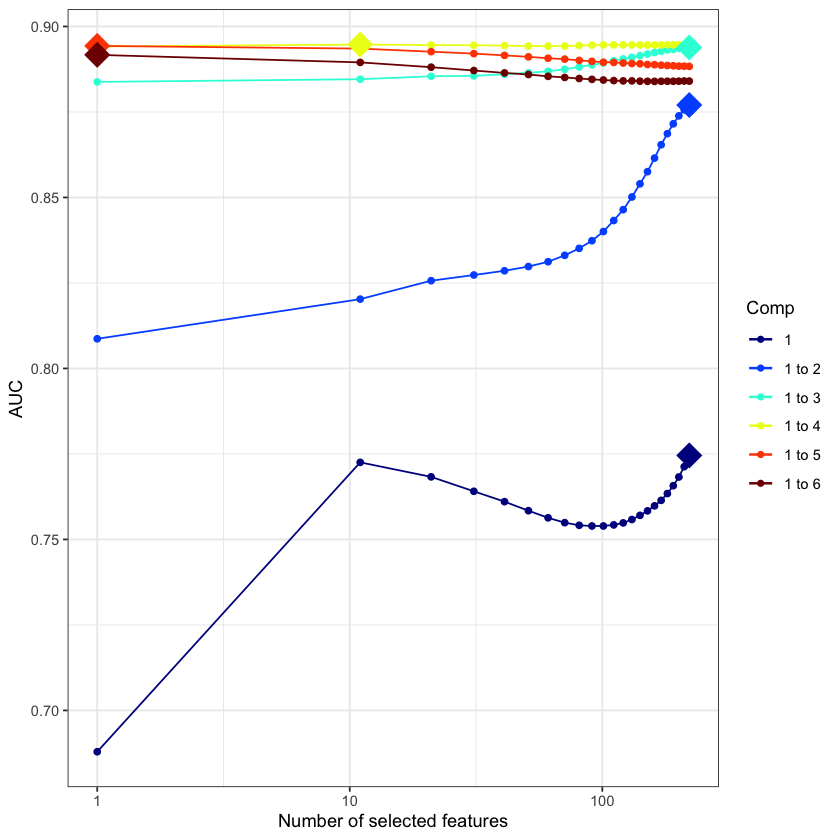

In [83]:
select.keepX <- tune.splsda.final$choice.keepX[1:ncomp]  # optimal number of variables to select
select.keepX
plot(tune.splsda.final, col = color.jet(6))

In [84]:
splsda_output_beta <- mixOmics::splsda(X = subset(train,select = -c(status)),
                                        Y = train$status,ncomp = 3,keepX=c(50,50,50))

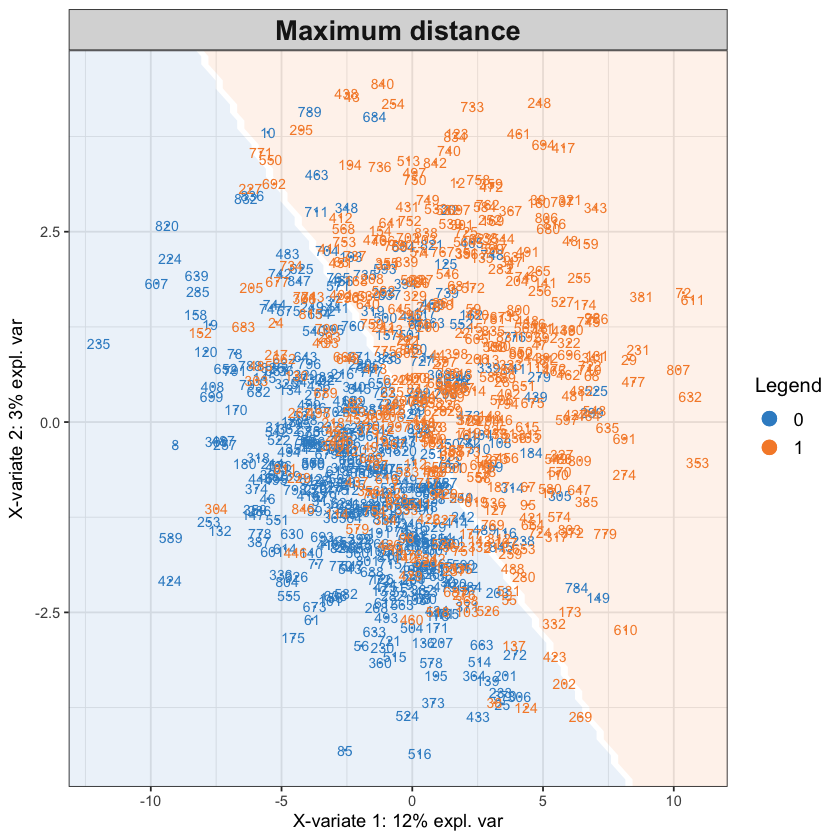

In [85]:
background = background.predict(splsda_output_beta, comp.predicted=2, dist = "max.dist") 

plotIndiv(splsda_output_beta, comp = 1:2,
          group = as.factor(train$status), title = "Maximum distance",
          legend = TRUE,  background = background)

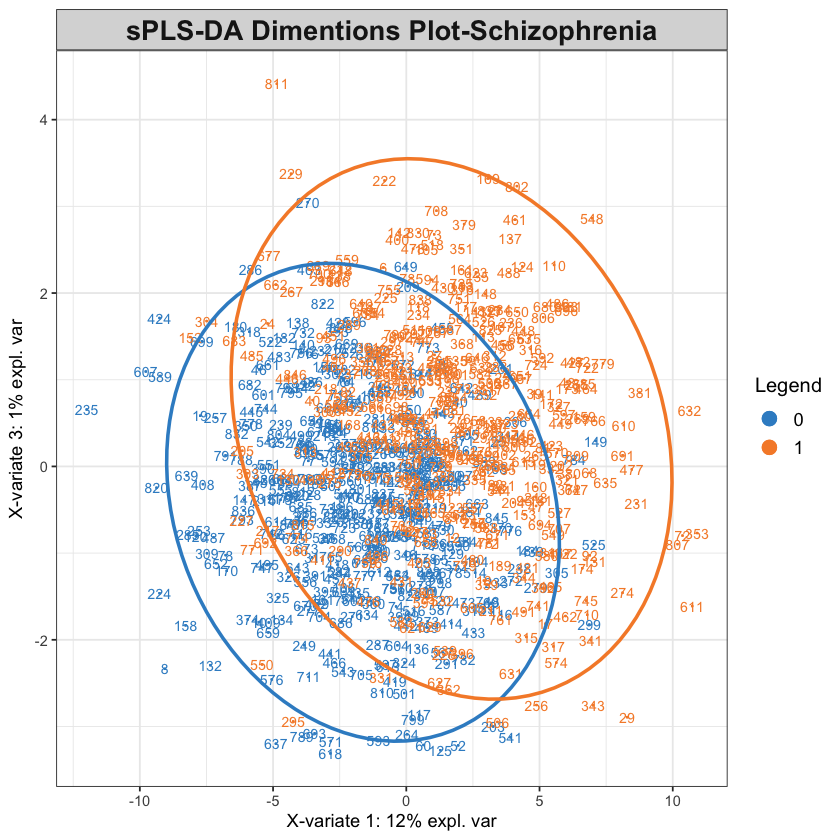

In [86]:
v <- plotIndiv(splsda_output_beta, legend=TRUE,comp = c(1,3),
               ellipse = T, star = FALSE, title = paste0('sPLS-DA Dimentions Plot-',"Schizophrenia"))

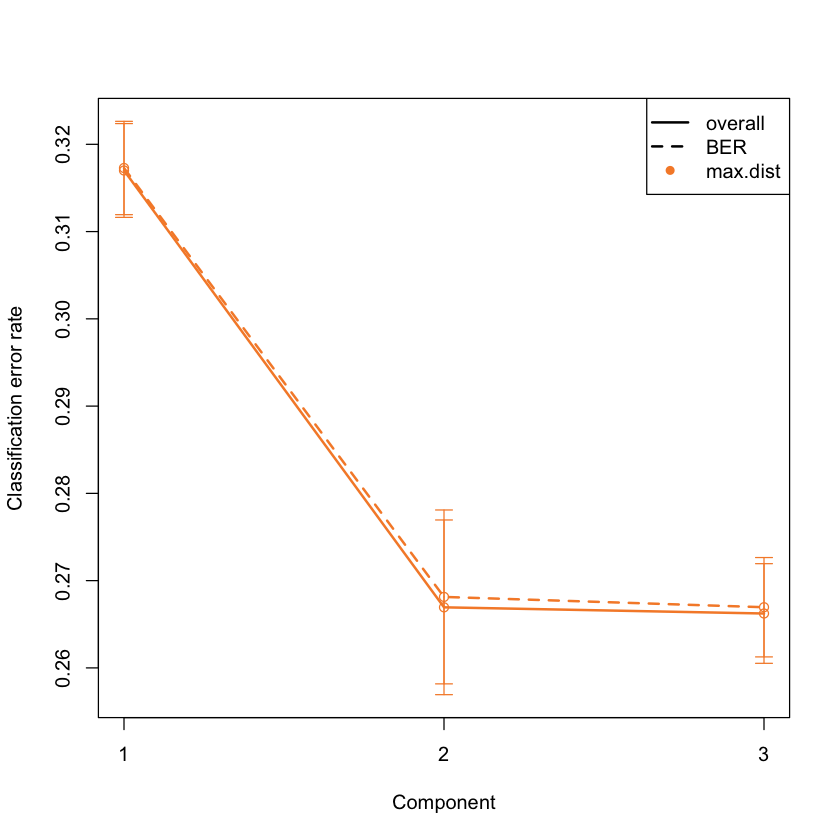

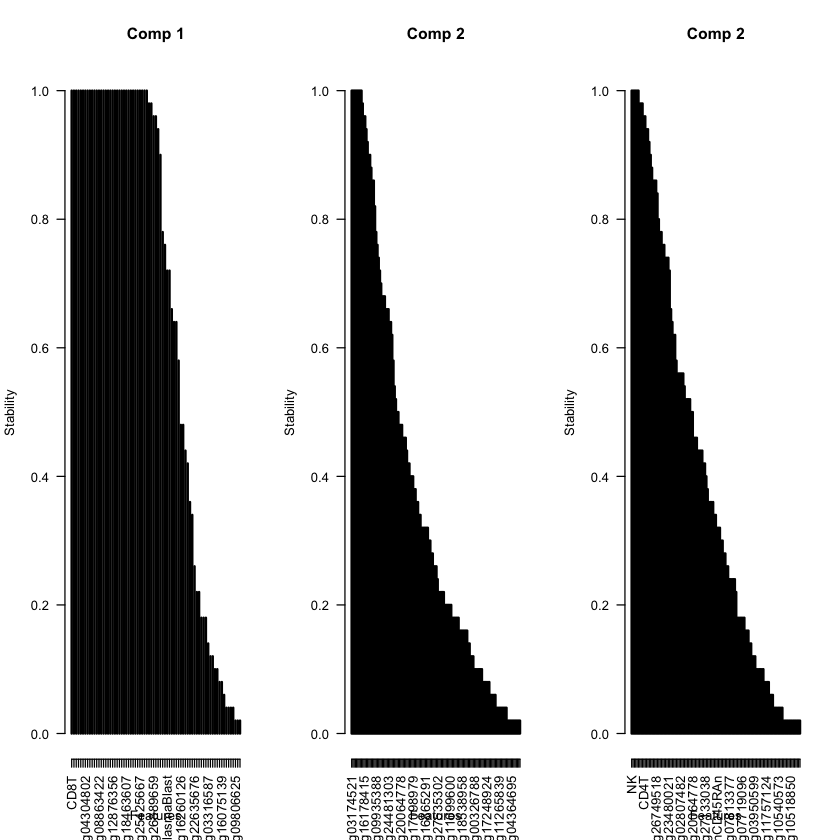

In [87]:
set.seed(40)
perf.srbct <- perf(splsda_output_beta, validation = "Mfold", folds = 5,
                   dist = 'max.dist', nrepeat = 10,
                   progressBar = FALSE) 
plot(perf.srbct, col = color.mixo(2))

par(mfrow=c(1,3))
plot(perf.srbct$features$stable[[1]], type = 'h', ylab = 'Stability', 
     xlab = 'Features', main = 'Comp 1', las =2)
plot(perf.srbct$features$stable[[2]], type = 'h', ylab = 'Stability', 
     xlab = 'Features', main = 'Comp 2', las =2)
plot(perf.srbct$features$stable[[3]], type = 'h', ylab = 'Stability', 
     xlab = 'Features', main = 'Comp 2', las =2)


ind.match = match(selectVar(splsda_output_beta, comp = 1)$name, 
                  names(perf.srbct$features$stable[[1]]))

Freq = as.numeric(perf.srbct$features$stable[[1]][ind.match])


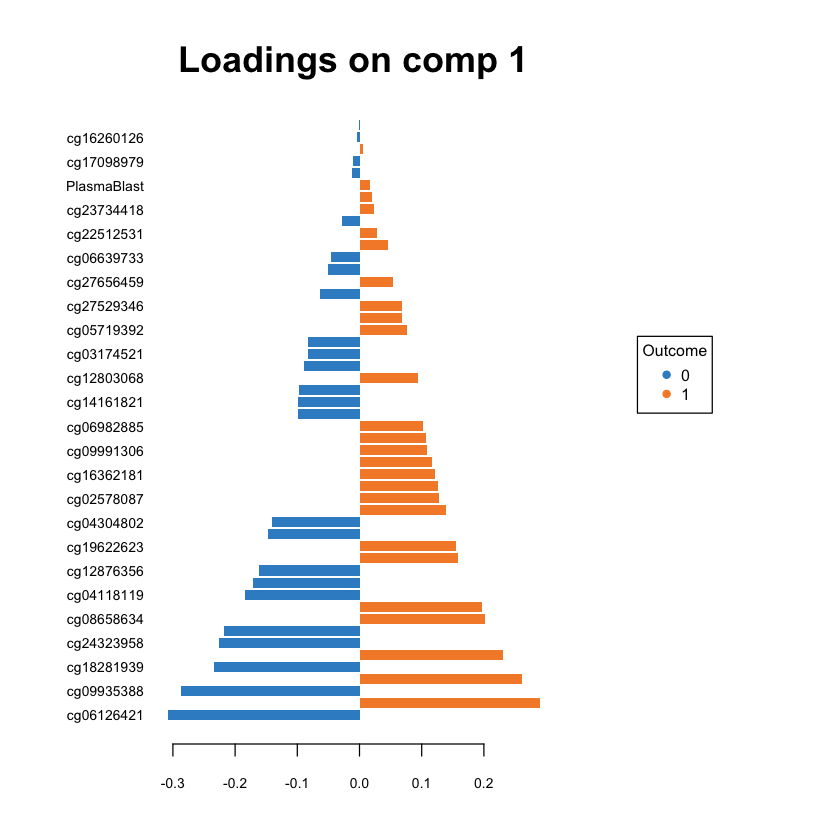

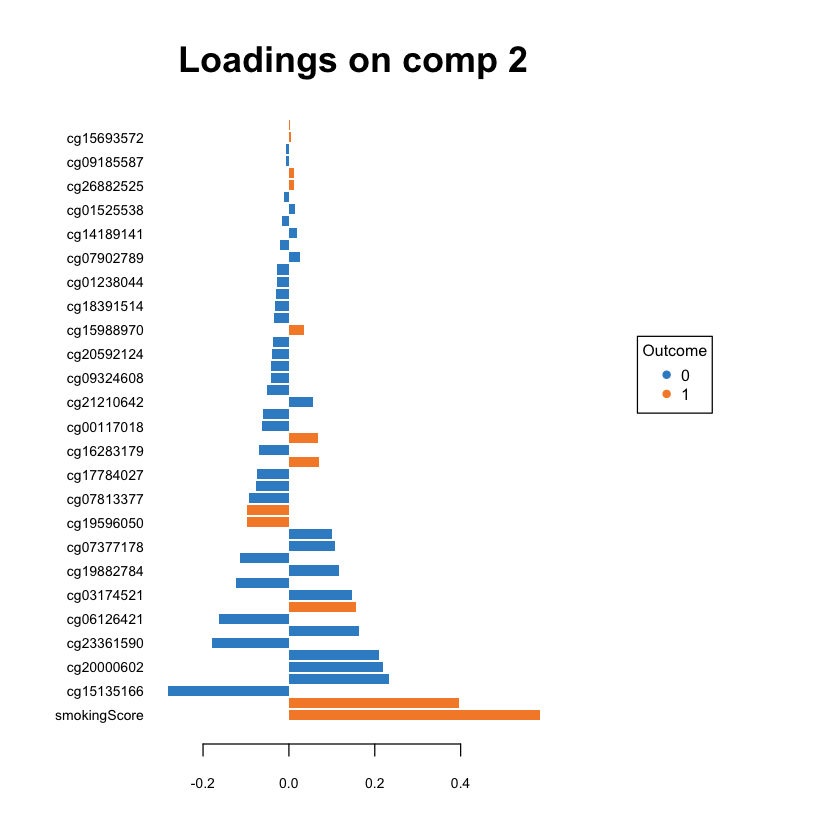

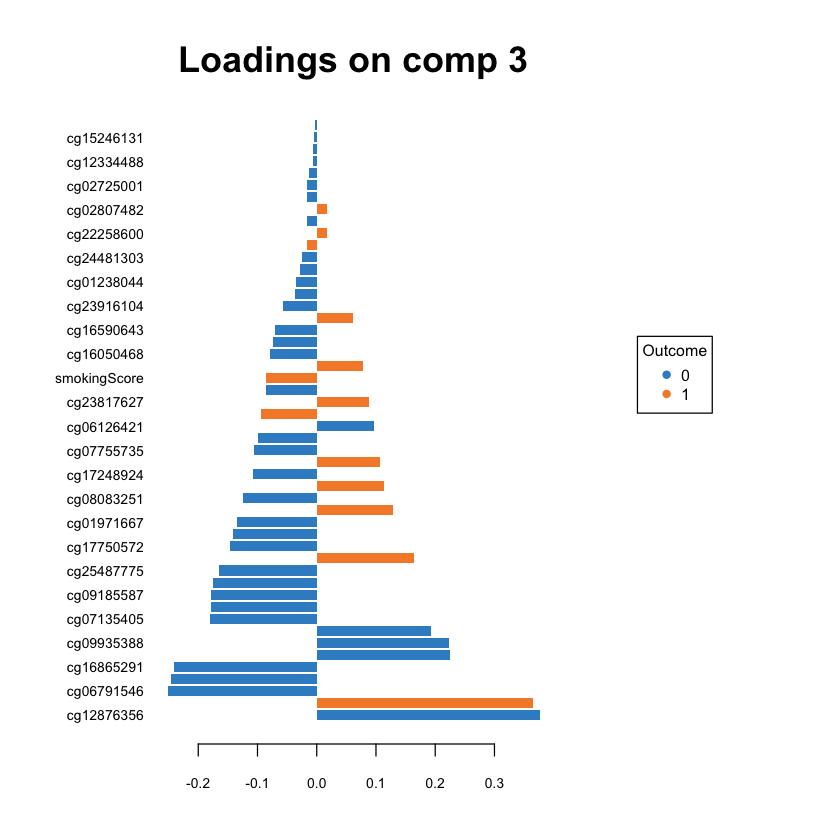

In [88]:
plotLoadings(splsda_output_beta, comp = 1, title = 'Loadings on comp 1', 
             contrib = 'max', method = 'mean')
plotLoadings(splsda_output_beta, comp = 2, title = 'Loadings on comp 2', 
             contrib = 'max', method = 'mean')
plotLoadings(splsda_output_beta, comp = 3, title = 'Loadings on comp 3', 
             contrib = 'max', method = 'mean')

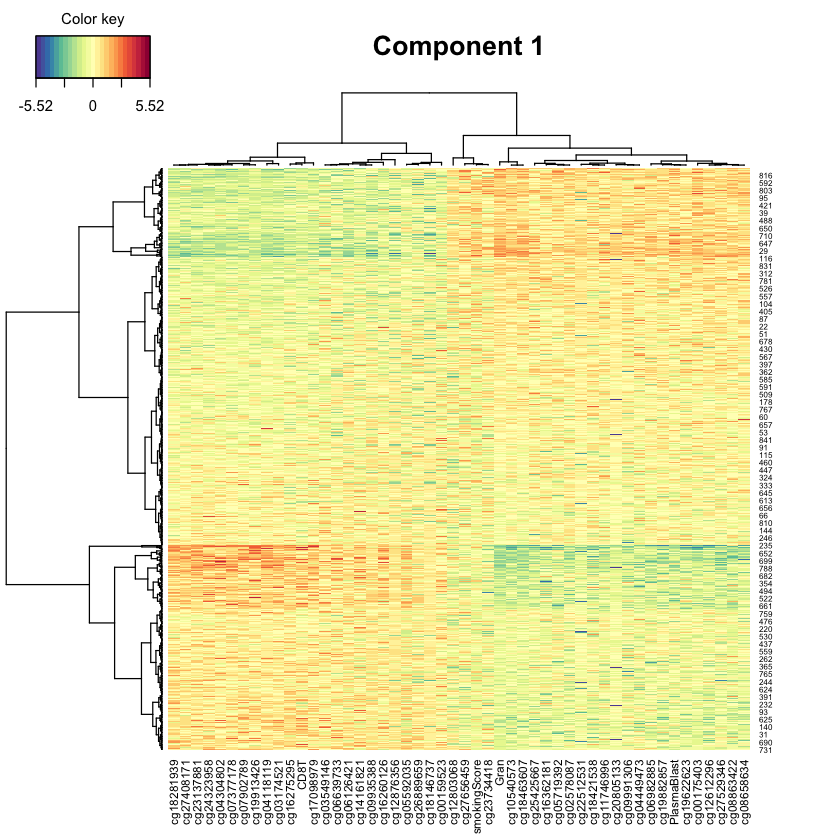

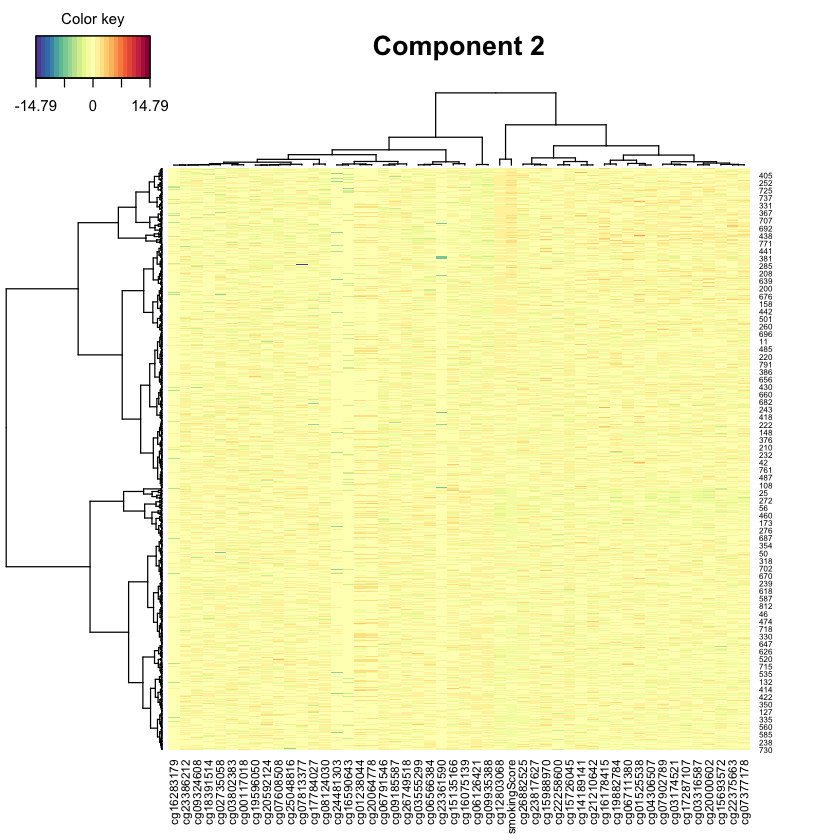

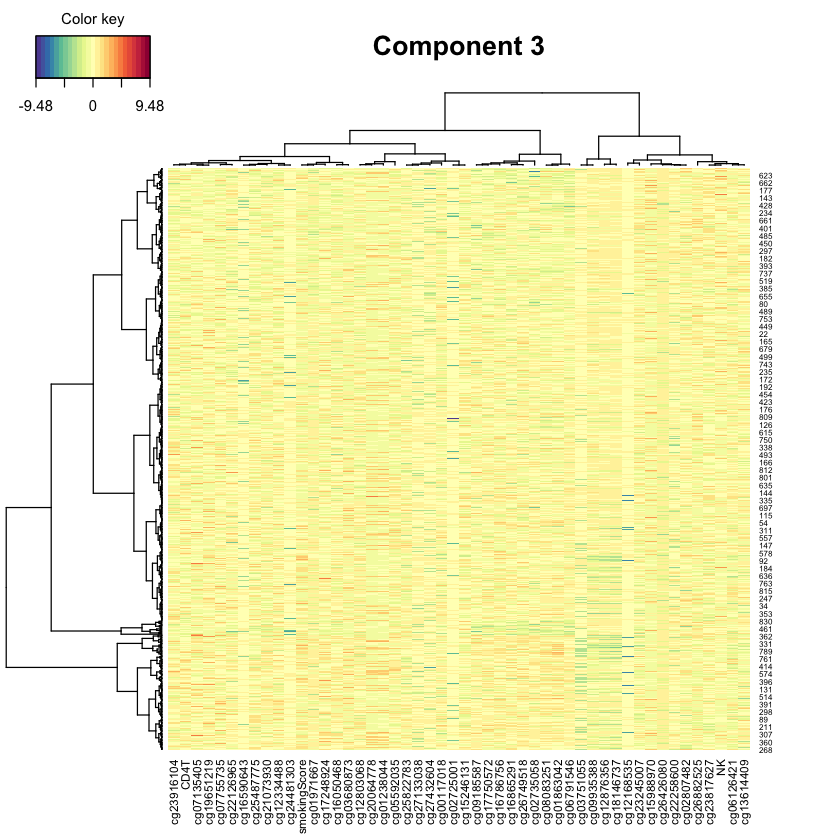

In [89]:
cim(splsda_output_beta,comp=1, title ="Component 1")
cim(splsda_output_beta,comp=2, title ="Component 2")
cim(splsda_output_beta,comp=3, title ="Component 3")

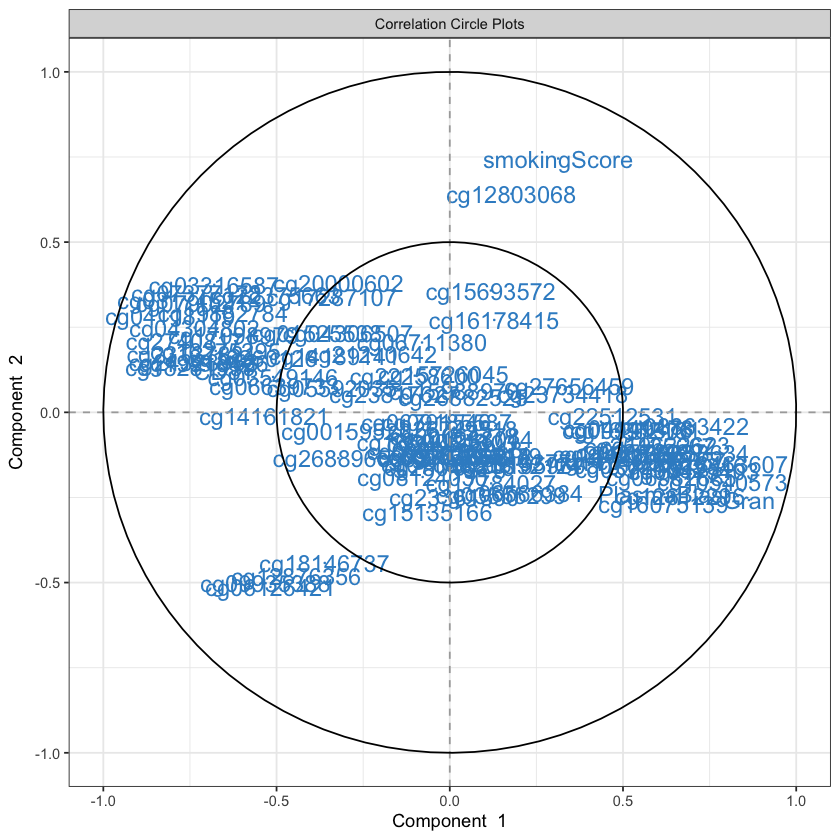

In [91]:
plotVar(splsda_output_beta)

Loading required package: scales



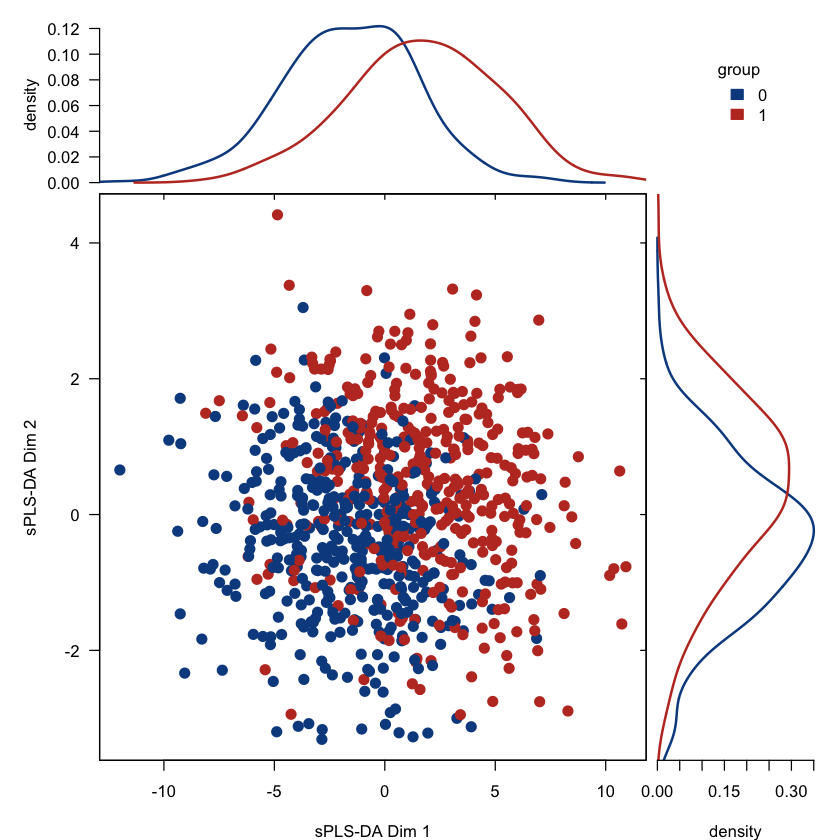

In [92]:
plsdaDF <- as.data.frame(v$df)
highest_x_y <- ceiling(max(max(abs(plsdaDF$x)),max(abs(plsdaDF$y))))
marginal_plot(x = x, y = y, group = group, data = v$df,
              bw = "nrd", lm_formula = NULL, xlab = "sPLS-DA Dim 1", ylab = "sPLS-DA Dim 2", pch = 16, cex =1.5)

In [94]:
library(raster)
library(pracma)
var(plsdaDF$x)
var(plsdaDF$y)
rad2deg(atan2(2,1))

Loading required package: sp


Attaching package: 'raster'


The following object is masked from 'package:ggpubr':

    rotate


The following object is masked from 'package:magrittr':

    extract


The following objects are masked from 'package:MASS':

    area, select


The following object is masked from 'package:data.table':

    shift



Attaching package: 'pracma'


The following objects are masked from 'package:magrittr':

    and, mod, or




[1] 12.96896

[1] 1.618497

[1] 63.43495

[1] 1.303957
[1] -0.905727


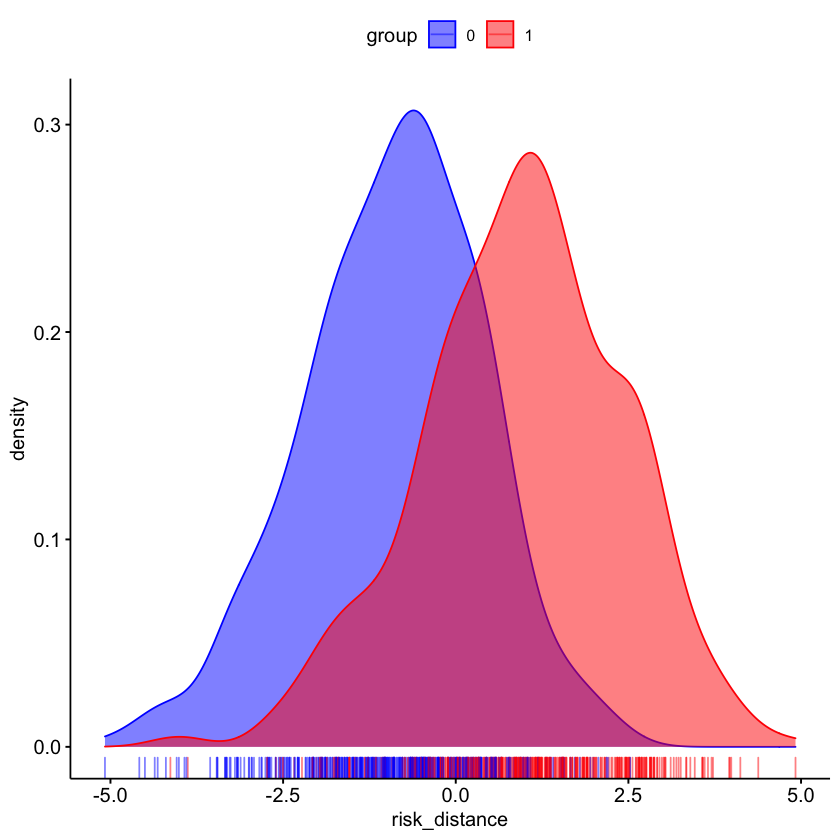

In [95]:
risk_distance <- function(DF){
    X <- as.numeric(DF[1])
    Y <- as.numeric(DF[2])
    d <- pointDistance(c(0,0),c(X,Y),lonlat = F)
    return(d*cos(atan2(Y,X) + deg2rad(180-rad2deg(atan2(3,1)))))# - for MBCN + for BC
    #return(d*cos(atan2(Y,X) + deg2rad(45)))# - for MBCN + for BC

}
plsdaDF$risk_distance <- -1*apply(plsdaDF, 1, risk_distance)
plot.data <- plsdaDF[c("group","risk_distance")]
ggdensity(plot.data, x = "risk_distance",
          rug = TRUE,
          color = "group", fill = "group",
          palette = c("blue", "red"))
stdev_controls <- sd(plot.data[plot.data$group==0,]$risk_distance)#increase n
mean_controls <- mean(plot.data[plot.data$group==0,]$risk_distance)
print(stdev_controls)
print(mean_controls)

In [96]:
dim(plot.data)

[1] 847   2

In [97]:
Y <- test$status

In [98]:
test <- test[colnames(splsda_output_beta$X)]

In [99]:
########### PREDICTION ######
##########################################################################

#test$status <- NULL
test.predict <- predict(splsda_output_beta, test)

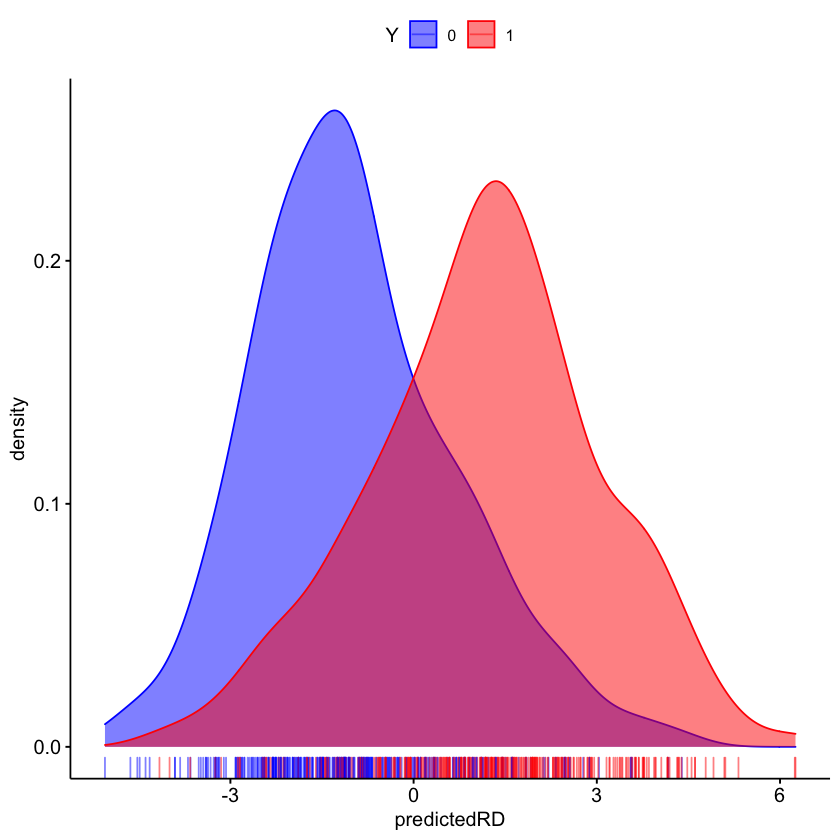

In [100]:
predicted_RD <- data.frame(-1*apply(test.predict$variates,1,risk_distance))
predicted_RD$Y <- as.numeric(as.character(Y))
colnames(predicted_RD) <- c("predictedRD","Y")

predicted_RD$Y <- as.factor(predicted_RD$Y)
ggdensity(predicted_RD, x = "predictedRD",
          rug = TRUE,
          color = "Y", fill = "Y",
          palette = c("blue", "red"))

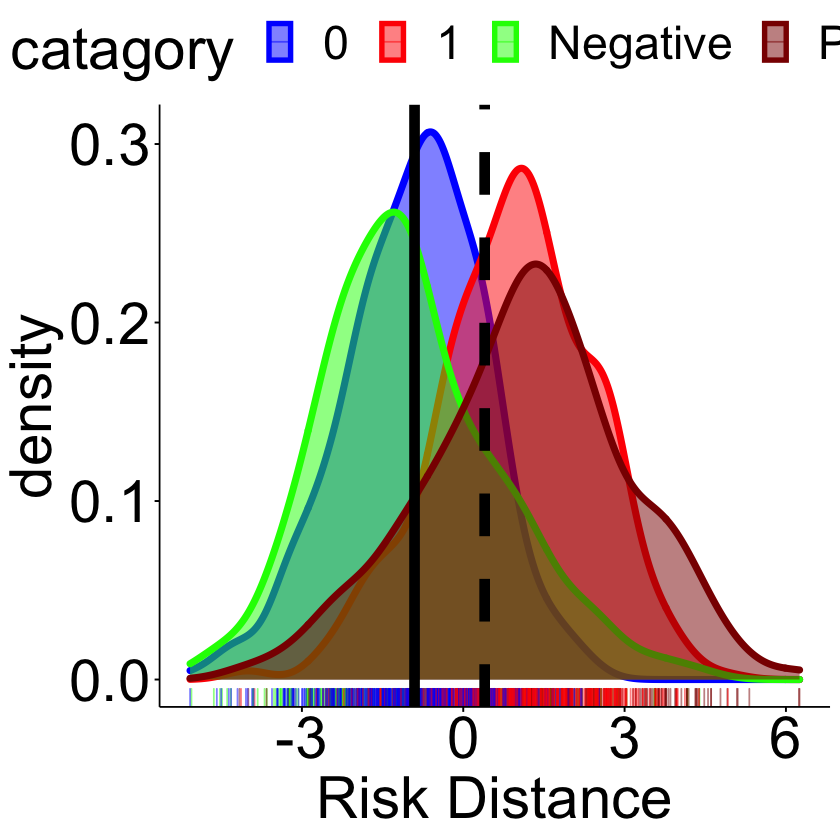

In [101]:
predicted_RD$catagory <- ifelse(predicted_RD$Y==0,"Negative","Positive")
colnames(plot.data) <- c("catagory","predictedRD")

final_RD_table <- rbind(
    predicted_RD[c("predictedRD","catagory")],
    plot.data[c("predictedRD","catagory")]
)
    
ggdensity(final_RD_table, x = "predictedRD",size = 2,
          rug = TRUE,
          color = "catagory", fill = "catagory",
          palette = c("blue", "red","green","darkred"))+
            geom_vline(xintercept =mean_controls ,lwd=3)+
            geom_vline(xintercept = (mean_controls+stdev_controls) ,linetype="dashed",lwd=3)+
                xlab("Risk Distance")+theme(text = element_text(size=35))

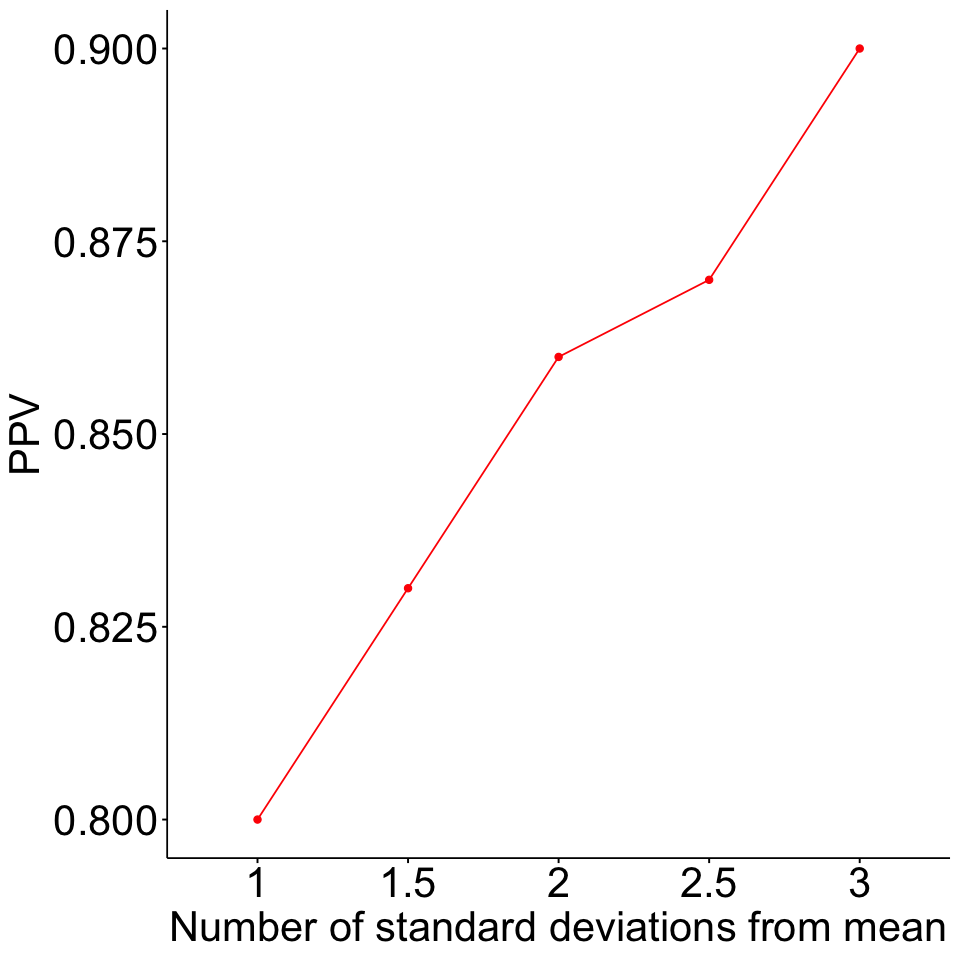

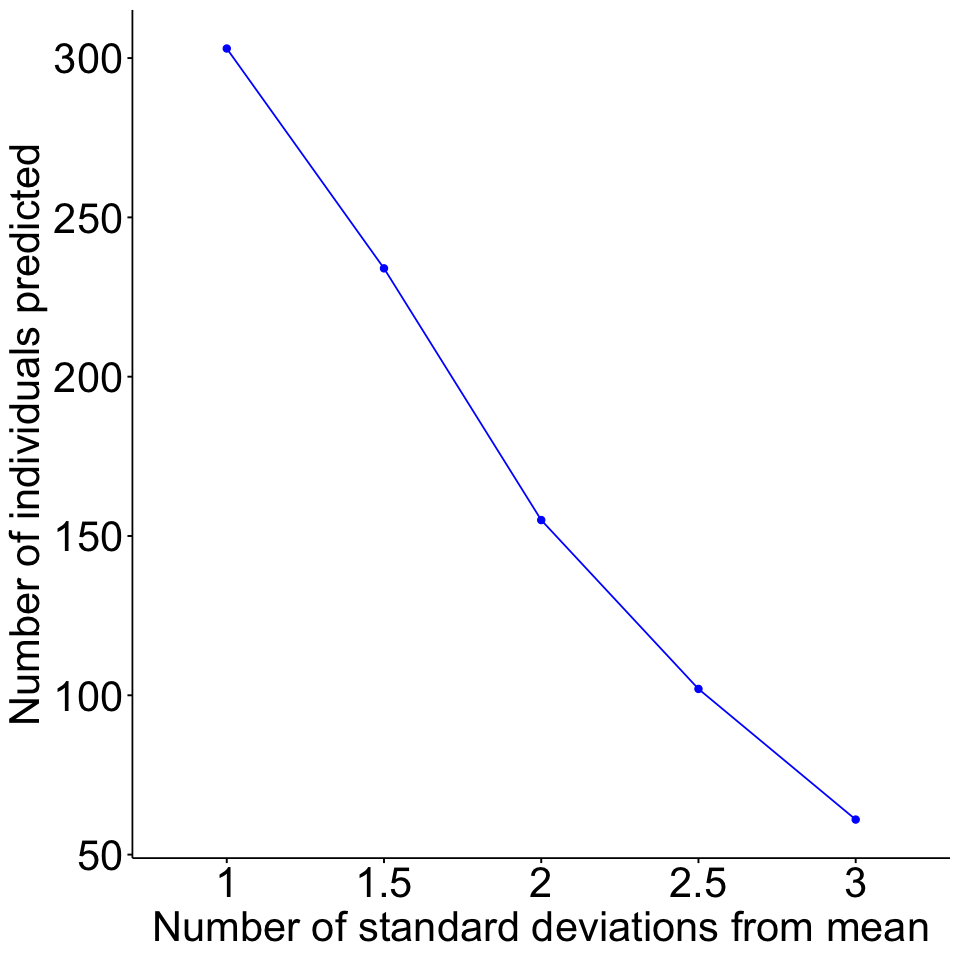

In [103]:
#################################################
PPV <-c()
num_of_predicted_ind <- c()
#stdev <- sd(plot.data[plot.data$catagory==0,]$risk_distance)#increase n
#mean_PRD <- mean(plot.data[plot.data$catagory==0,]$risk_distance)
n_controls <- c()
n_cases <- c()


for(n in seq(1,3,0.5)){
    cutoff <- n*stdev_controls
    cutoff <- mean_controls + cutoff
    
    predicted_RD_cutoff <- predicted_RD[predicted_RD$predictedRD>cutoff,]
    #n_controls_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==0,])[1]
    #n_cases_in_sd <- dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1,])[1]
    predicted_RD_cutoff$predicted_Y <- as.numeric(ifelse(predicted_RD_cutoff$predictedRD>=cutoff,1,0))
    
    PPV <- c(PPV,
             dim(predicted_RD_cutoff[predicted_RD_cutoff$Y==1 & predicted_RD_cutoff$predicted_Y==1 ,])[1]/dim(predicted_RD_cutoff[predicted_RD_cutoff$predicted_Y==1 ,])[1])
    num_of_predicted_ind <- c(num_of_predicted_ind,dim(predicted_RD_cutoff)[1])
}
test_results <- data.frame(x=seq(1,3,0.5),y=round(PPV,2),num_of_predicted_ind)
options(repr.plot.width=8, repr.plot.height=8)
ggline(test_results, x = "x", y = "y",color = "red",xlab="Number of standard deviations from mean",ylab="PPV")+
theme(text = element_text(size=25))
ggline(test_results, x = "x", y = "num_of_predicted_ind",color = "blue",
       xlab="Number of standard deviations from mean",ylab="Number of individuals predicted")+
theme(text = element_text(size=25))


In [104]:
num_of_predicted_ind
PPV

[1] 303 234 155 102  61

[1] 0.7986799 0.8333333 0.8580645 0.8725490 0.9016393